In [2]:
!pip3 install deap
!pip3 install statsmodels
!pip3 install scipy


  Using cached deap-1.4.1.tar.gz (1.1 MB)
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/d2/2f/b42860931c1479714201495ffe47d74460a916ae426a21fc9b68c5e329aa/numpy-1.26.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 18.6 MB/s eta 0:00:0000:0100:01
  Created wheel for deap: filename=deap-1.4.1-py3-none-any.whl size=97316 sha256=00bb1a08c158aebfe3f5f25d98d25e15e042b5a54af08056b8edb03cf91a046d
  Stored in directory: /Users/shifatsahariar/Library/Caches/pip/wheels/f8/64/b8/65eacfbff3024ae2e2beb22e691d5c8abb89fbd863b8049b5f
Successfully built deap
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 21.4 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for scipy!=1.9.2,>=1.4 from https://files.pythonhosted.org/packages/b1/a6/b6d66d4f4045ba59200d25f254

### Imports

In [67]:
import random
from deap import base, creator, tools
import statsmodels.api as sm
import scipy.stats as stats


### Minimization Problem 

In [68]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


In [69]:
toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 1, 100)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [70]:
def evaluate(individual):
    a, b, c = individual
    return abs(a**2 + b**2 - c**2),

In [71]:
toolbox.register("evaluate", evaluate)

In [72]:
def mutate(individual):
    index = random.randint(0, 2)  # Choose a random index in [0, 1, 2]
    individual[index] = random.randint(1, 100)  # Assign a new random value
    return individual,


In [73]:
toolbox.register("mate", tools.cxOnePoint)
#toolbox.register("mutate", tools.mutUniformInt, low=1, up=100, indpb=0.2)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)


## **Genetic Algorithm Execution: Main Function**

In [74]:
def main():
    pop = toolbox.population(n=300)
    # Define the probability
    # CXPB - Crossover Probability, MUTPB - Mutation Probability, NGEN - Number of Generations
    CXPB, MUTPB, NGEN = 0.5, 0.2, 40
        # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    # Assigning the evaluated fitness to corresponding individuals
    for ind, fit in zip(pop, fitnesses):# For each individual and corresponding fitness value
        ind.fitness.values = fit # Assign the fitness value to the individual’s fitness attribute
    
    for gen in range(NGEN):
        # Selecting individuals to form the next generation based on their fitness using Tournament Selection.
        offspring = toolbox.select(pop, len(pop))
        # Creating a deep copy of the offspring to ensure that modifications in offspring do not affect the original individuals.
        offspring = list(map(toolbox.clone, offspring))
        
        # offspring[::2] gets all even indices of the offspring list, => all offspring at positions 0, 2, 4, ...
        # offspring[1::2] gets all odd indices of the offspring list, => all offspring at positions 1, 3, 5, ...
        # For each pair of adjacent offspring (child1 from even indices, and child2 from odd indices)
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            # A random float between 0 and 1 is compared to CXPB to decide whether to perform crossover.
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        
        for mutant in offspring:
            # For each individual, there is a MUTPB chance it will undergo mutation.
            if random.random() < MUTPB:
                # If selected for mutation, perform mutation operation on the individual.
                toolbox.mutate(mutant)
                # After mutation, delete the fitness values as they are no longer valid.
                del mutant.fitness.values
        # Find the individuals in the offspring population whose fitness is invalid
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        # Evaluate the fitness of invalid individuals
        # Compute the fitness of each invalid individual using the evaluate function
        fitnesses = map(toolbox.evaluate, invalid_ind)
         # Assign the newly computed fitness values to the corresponding individuals
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        # Replacing with new population
        pop[:] = offspring
    
    return pop


## **Evaluating Genetic Algorithm Effectiveness**

### **1. Algorithm Execution:**
We are executing the Genetic Algorithm `N` times to systematically observe its capability to consistently identify Pythagorean triples.

### **2. Success Rate Calculation:**
The success rate is quantified as the ratio of the number of successful runs to the total number of executions, `N`. A run is considered successful if the algorithm is able to identify a Pythagorean triple within the population.


In [76]:
N = 20
successes = 0
for _ in range(N):
    population = main()
    for ind in population:
        a, b, c = ind
        if a**2 + b**2 == c**2:
            successes += 1
            break

success_rate = successes / N
print("Success rate: ", success_rate)


Success rate:  0.2


### Estimating Confidence Interval Using Wilson's Method

We used Wilson's method for calculating the confidence interval of a proportion, 
particularly beneficial when dealing with proportions near 0 or 1, offering more accurate intervals.

In this analysis, the `proportion_confint` function from the `statsmodels.stats.proportion` library is employed with the Wilson method to estimate the confidence interval of the program's success rate, defined as the proportion of successful runs over total runs (`N`). 

- **Function Used:** `proportion_confint`
- **Library:** `statsmodels.stats.proportion`
- **Method:** Wilson
- **Confidence Level:** 95% (alpha=0.05)

```python
ci_low, ci_upp = sm.stats.proportion_confint(successes, N, alpha=0.05, method='wilson')


In [77]:
ci_low, ci_upp = sm.stats.proportion_confint(successes, N, alpha=0.05, method='wilson')
print(f"Confidence interval: ({ci_low:.2f}, {ci_upp:.2f})")


Confidence interval: (0.08, 0.42)


### **Random Method Execution**

In [78]:
random_successes = 0
for _ in range(N):
    # Generate two random integers 'a' and 'b' between 1 and 100
    a = random.randint(1, 100)
    b = random.randint(1, 100)
    # Select 'c' such that it is the maximum of 'a' and 'b' to satisfy the Pythagorean theorem condition
    c = random.randint(max(a,b), 100)
    if a**2 + b**2 == c**2:
        random_successes += 1



### **Comparison via Fisher's Exact Test**

In [79]:
# Construct a 2x2 contingency table where:
# Perform a Fisher's exact test on the table to compare the success rates of the Genetic Algorithm and Random Generator
oddsratio, pvalue = stats.fisher_exact([[successes, N - successes], [random_successes, N - random_successes]])
print(f"P-Value from Fisher's exact test: {pvalue}")

P-Value from Fisher's exact test: 0.10602910602910605


` Since the p-value is greater than 0.05, there is not enough evidence to reject the null hypothesis, suggesting that, based on this sample, there is not a statistically significant difference between the success rate of the genetic algorithm and that of a random generator in finding Pythagorean triples`


In [65]:
!pip3 install matplotlib


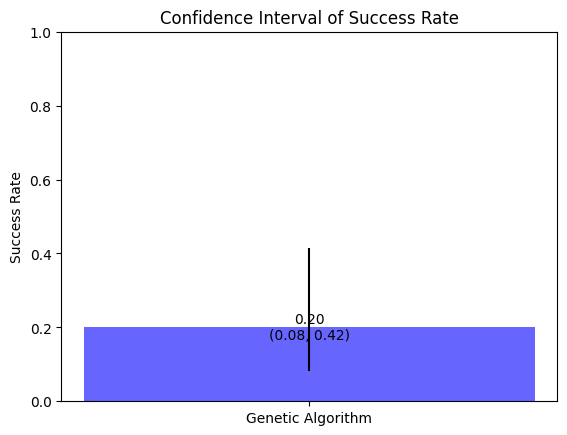

In [66]:
import matplotlib.pyplot as plt

# Success rate is the height of the bar
# The error is the difference between the success rate and the limits of the confidence interval
error = [[success_rate - ci_low], [ci_upp - success_rate]]

plt.bar('Genetic Algorithm', success_rate, yerr=error, color='blue', alpha=0.6)
plt.ylabel('Success Rate')
plt.title('Confidence Interval of Success Rate')
plt.ylim(0, 1)  # as success rate is a probability, it is between 0 and 1

# Showing the exact value of success rate and confidence interval on the plot
plt.text('Genetic Algorithm', success_rate, f'{success_rate:.2f}\n({ci_low:.2f}, {ci_upp:.2f})', ha='center', va='center', fontsize=10, color='black')

plt.show()
